<a href="https://colab.research.google.com/github/Cyusa8/ML-projects/blob/main/Project_priority_level_prediction_with_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
  #load required modules
#general module
import sys
import io
import zipfile
import requests
from io import BytesIO
from sklearn.preprocessing import StandardScaler
#import data module
import numpy as np
import pandas as pd
#import machine learning module
from tensorflow import keras
#data visualisation module
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
raw_df = pd.read_csv('/content/drive/MyDrive/large_project_priority_data.csv')
training_df = raw_df[['Estimated Cost (in $)','Community Benefit Score','Stakeholder Engagement Score','Priority Value']]
training_df.index
training_df.head()
print(training_df.info())

#2 Extract features and labels
feature_names = ['Estimated Cost (in $)', 'Community Benefit Score', 'Stakeholder Engagement Score']
label_name = 'Priority Value'
features = training_df.loc[:, feature_names].values
labels = training_df[label_name].values.reshape(-1, 1)  # reshape for scaling

# 3. Scale the features and label
feature_scaler = StandardScaler()
label_scaler = StandardScaler()

features_scaled = feature_scaler.fit_transform(features)
labels_scaled = label_scaler.fit_transform(labels)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Estimated Cost (in $)         1000 non-null   int64  
 1   Community Benefit Score       1000 non-null   int64  
 2   Stakeholder Engagement Score  1000 non-null   int64  
 3   Priority Value                1000 non-null   float64
dtypes: float64(1), int64(3)
memory usage: 31.4 KB
None


In [ ]:
training_df.describe(include='all')

,Estimated Cost (in $),Community Benefit Score,Stakeholder Engagement Score,Priority Value
count,1000.000000,1000.000000,1000.00000,1000.000000
mean,245679.568000,50.089000,48.44600,49.312828
std,140316.549896,29.309557,29.21761,16.356126
min,10051.000000,0.000000,0.00000,1.949479
25%,122890.250000,24.000000,24.00000,38.457918
50%,242653.000000,51.000000,48.00000,49.711113
75%,368214.250000,75.000000,73.00000,61.126907
max,499910.000000,100.000000,100.00000,95.495823


<Axes: >

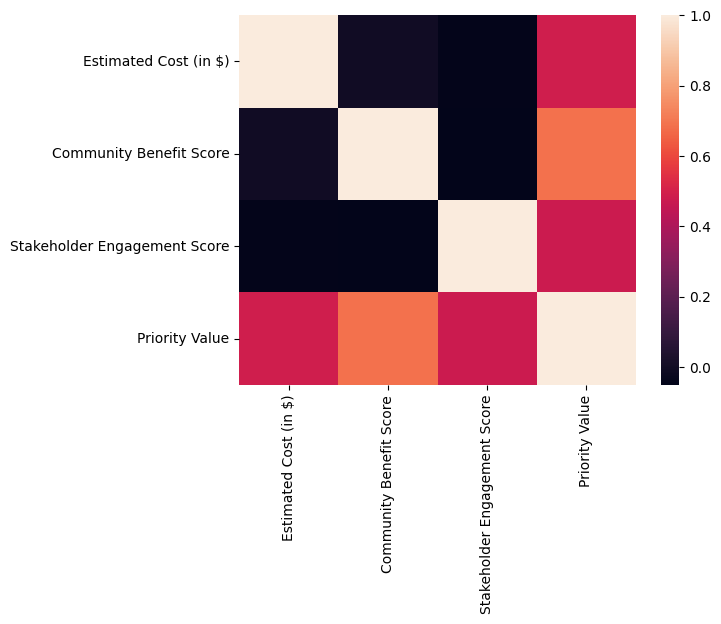

In [ ]:
sns.heatmap(training_df.corr())

In [ ]:
#Build a model function (build and compile a simple linear regression model)
def build_model(my_learning_rate, num_feature):

  # Define the input layer.
  # shape=(num_features,) specifies the shape of the input data.
  inputs = keras.Input(shape=(num_feature,))

  # Define the output layer.
  # units=1 means the output layer has a single neuron (for regression).
  outputs = keras.layers.Dense(units=1)(inputs)

  # Create the Keras model by specifying inputs and outputs.
  model = keras.Model(inputs=inputs, outputs=outputs)

  # Compile the model.
  '''Optimizer: RMSprop (Root Mean Square Propagation) with the given learning rate dtermining how
      the model updates its weights and biases.'''
  # Loss function: Mean Squared Error (common for regression).
  # Metric: Root Mean Squared Error (for evaluation).
  model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=my_learning_rate),
                loss='mean_squared_error',
                metrics=[keras.metrics.RootMeanSquaredError()])

  # Return the compiled model.
  return model

''' After  building our model we need to train it by feeding it data '''
#define a function to train the model
def train_model (model, df, features, label, epochs, batchsize): #Fixed indentation here
  #Feed our model the data
  history = model.fit(x=features, y=label, batch_size=batchsize, epochs=epochs)
  #gather trained model's weight and bias and store
  trained_weight = model.get_weights()[0]
  trained_bias = model.get_weights()[1] #Fixed: get_bias() to get_weights()[1] to get bias

  #We store epochs separately from the rest of the history
  epochs = history.epoch

  #We Isolate errors for each epoch note that Epoch simply means nbr of training iterations
  hist = pd.DataFrame(history.history)

  #we track the progress of our model by taking snapshots of our model's rmse at each epoch(iteration)
  rmse = hist['root_mean_squared_error'] #Fixed: using string 'root_mean_squared_error' to access column

  return trained_weight, trained_bias, epochs, rmse


#Define run_experiment function
def run_experiment(df, feature_names, label_name, learning_rate, epochs, batch_size):
  #display info message about the experiment
  print('INFO: Start training experiment with features={} and label={}\n'.format(feature_names, label_name))
  num_feature = len(feature_names) #calculate the nbr of features being used

  '''We extract feature and label values and store them in separate variables(features, label)
  the ".value" is to convert the values into numpy arrays for better computation and "df.loc"
  specifies which column to extract from the dataframe'''
  #Fixed indentation here
  features = df.loc[:,feature_names].values #Fixed: feature_name to feature_names, .value to .values
  label = df[label_name].values #Fixed: df[:,label_name].value to df[label_name].values for correct column selection

  #model building and training
  model = build_model(learning_rate, num_feature)
  model_output = train_model(model, df, features, label, epochs, batch_size) #Fixed indentation here

  #Display results and visualisation
  print('\n SUCCESS:Training Experiment Complete\n')
  print('\n{}'.format(model_info(feature_names, label_name, model_output)))
  make_plots(df, feature_names, label_name, model_output)

  #Return trained model
  return model

print("SUCCESS: defining linear regression functions complete.")

NameError: name 'X_train' is not defined

In [ ]:
#@title Define plotting functions

# This function creates and displays two plots: a loss curve and a model plot.
def make_plots(df, feature_names, label_name, model_output, sample_size=50):
  """
  Generates and displays two plots: a loss curve and a model plot.

  Args:
    df: The pandas DataFrame containing the data.
    feature_names: A list of the features(elements to use when predicting) used in the model.
    label_name: The name of the label or target variable.
    model_output: A tuple containing the model's weights, bias, epochs, and RMSE.
    sample_size: The number of data points to sample for plotting (default: 200).
  """

  # Take a random sample of the data for plotting.
  random_sample = df.sample(n=sample_size).copy()
  # Reset the index of the sample.
  random_sample.reset_index()
  # Unpack the model output into weights, bias, epochs, and RMSE.
  weights, bias, epochs, rmse = model_output

  # Determine if it's a 2D or 3D plot based on the number of features.
  is_2d_plot = len(feature_names) == 1
  # Set the plot type accordingly ("scatter" for 2D, "surface" for 3D).
  model_plot_type = "scatter" if is_2d_plot else "surface"
  # Create a subplot figure with two panels: one for the loss curve and one for the model plot.
  fig = make_subplots(rows=1, cols=2,
                      subplot_titles=("Loss Curve", "Model Plot"),
                      specs=[[{"type": "scatter"}, {"type": model_plot_type}]])

  # Call the plot_data function to plot the actual data points.
  plot_data(random_sample, feature_names, label_name, fig)
  # Call the plot_model function to plot the model's predictions.
  plot_model(random_sample, feature_names, weights, bias, fig)
  # Call the plot_loss_curve function to plot the model's loss over epochs.
  plot_loss_curve(epochs, rmse, fig)

  # Display the figure.
  fig.show()
  return

# This function plots the loss curve of the model.
def plot_loss_curve(epochs, rmse, fig):
  """
  Plots the loss curve of the model.

  Args:
    epochs: A list of epoch numbers.
    rmse: A list of corresponding RMSE values.
    fig: The Plotly figure to add the loss curve to.
  """
  # Create a line plot of the RMSE values over epochs.
  curve = px.line(x=epochs, y=rmse)
  # Customize the line color and width.
  curve.update_traces(line_color='#ff0000', line_width=3)

  # Add the loss curve to the first subplot (row 1, column 1).
  fig.append_trace(curve.data[0], row=1, col=1)
  # Set the x-axis title to "Epoch".
  fig.update_xaxes(title_text="Epoch", row=1, col=1)
  # Set the y-axis title to "Root Mean Squared Error" and adjust the range.
  fig.update_yaxes(title_text="Root Mean Squared Error", row=1, col=1, range=[rmse.min()*0.8, rmse.max()])

  return

# This function plots the actual data points.
def plot_data(df, features, label, fig):
  """
  Plots the actual data points.

  Args:
    df: The pandas DataFrame containing the data.
    features: A list of feature names to plot.
    label: The name of the label or target variable.
    fig: The Plotly figure to add the data plot to.
  """
  # Create a scatter plot (2D or 3D depending on the number of features).
  if len(features) == 1:
    scatter = px.scatter(df, x=features[0], y=label)
  else:
    scatter = px.scatter_3d(df, x=features[0], y=features[1], z=label)

  # Add the scatter plot to the second subplot (row 1, column 2).
  fig.append_trace(scatter.data[0], row=1, col=2)
  # Set the axis titles according to the features and label.
  if len(features) == 1:
    fig.update_xaxes(title_text=features[0], row=1, col=2)
    fig.update_yaxes(title_text=label, row=1, col=2)
  else:
    fig.update_layout(scene1=dict(xaxis_title=features[0], yaxis_title=features[1], zaxis_title=label))

  return

# This function plots the model's predictions.
def plot_model(df, features, weights, bias, fig):
  """
  Plots the model's predictions.

  Args:
    df: The pandas DataFrame containing the data.
    features: A list of feature names used in the model.
    weights: The model's weights.
    bias: The model's bias.
    fig: The Plotly figure to add the model plot to.
  """
  # Calculate the predicted values using the model's equation.
  df['Priority_Value_Predicted'] = bias[0]

  for index, feature in enumerate(features):
    df['Priority_Value_Predicted'] = df['Priority_Value_Predicted'] + weights[index][0] * df[feature]

  # Create a line plot (2D or surface plot for 3D) for the model's predictions.
  if len(features) == 1:
    model = px.line(df, x=features[0], y='Priority_Value_Predicted')
    model.update_traces(line_color='#ff0000', line_width=3)
  else:
    z_name, y_name = "Priority_Value_Predicted", features[1]
    z = [df[z_name].min(), (df[z_name].max() - df[z_name].min()) / 2, df[z_name].max()]
    y = [df[y_name].min(), (df[y_name].max() - df[y_name].min()) / 2, df[y_name].max()]
    x = []
    for i in range(len(y)):
      x.append((z[i] - weights[1][0] * y[i] - bias[0]) / weights[0][0])

    plane=pd.DataFrame({'x':x, 'y':y, 'z':[z] * 3})

    light_yellow = [[0, '#89CFF0'], [1, '#FFDB58']]
    model = go.Figure(data=go.Surface(x=plane['x'], y=plane['y'], z=plane['z'],
                                      colorscale=light_yellow))

  # Add the model plot to the second subplot (row 1, column 2).
  fig.add_trace(model.data[0], row=1, col=2)

  return

# This function generates information about the model, including weights, bias, and the model's equation.
def model_info(feature_names, label_name, model_output):
  """
  Generates information about the model, including weights, bias, and the model's equation.

  Args:
    feature_names: A list of feature names used in the model.
    label_name: The name of the label or target variable.
    model_output: A tuple containing the model's weights and bias.

  Returns:
    A formatted string containing the model information.
  """
  weights = model_output[0]
  bias = model_output[1]

  nl = "\n"
  header = "-" * 80
  banner = header + nl + "|" + "MODEL INFO".center(78) + "|" + nl + header

  info = ""
  equation = label_name + " = "

  for index, feature in enumerate(feature_names):
    info = info + "Weight for feature[{}]: {:.3f}\n".format(feature, weights[index][0])
    equation = equation + "{:.3f} * {} + ".format(weights[index][0], feature)

  info = info + "Bias: {:.3f}\n".format(bias[0])
  equation = equation + "{:.3f}\n".format(bias[0])

  return banner + nl + info + nl + equation

print("SUCCESS: defining plotting functions complete.")

SUCCESS: defining plotting functions complete.


In [ ]:
#Experiment 1
#initialise hyperparameters
learning_rate = 0.001 #too big model learns too fast might miss something too learning rate model learns so slow and might take you time
epochs = 100 #iterations to go through while adjusting our bias and weights to achieve good prediction power
batch_size = 20 #this is the size of data to be used in each  iteration

#specify label and features
feature = ['Community Benefit Score']
label = 'Priority Value'

#call the run experiment function

model_1 = run_experiment (training_df, feature, label, learning_rate, epochs, batch_size)

INFO: Start training experiment with features=['Community Benefit Score'] and label=Priority Value

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2337.5024 - root_mean_squared_error: 48.3121
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1957.9031 - root_mean_squared_error: 44.2342
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1770.2469 - root_mean_squared_error: 42.0642
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1551.7694 - root_mean_squared_error: 39.3888
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1375.2493 - root_mean_squared_error: 37.0661
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1200.0935 - root_mean_squared_error: 34.6280
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1065.9977 - root_mean_squared_error: 32.6442
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 845.3683 - root_mean_squared_error: 29.0693
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 779.2198 -